<a href="https://colab.research.google.com/github/mjiii25/22-1_DLAI/blob/main/chapter07_working-with-keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Working with Keras: A deep dive

## A spectrum of workflows

- Keras API make it easy to get started, yet make it possible to handle high-complexity use cases
- easy, approachable, can apply complex methods

## Different ways to build Keras models

< APIs for building models >
- sequential model : simple stacks of layers
- functional API : focuses on grpah-like model architectures
- model subclassing : a low-level option where you write everyhing yourself.

### The Sequential model

**The `Sequential` class**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([                                                            # construct sequential model by keras.Sequential()
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [2]:
model.layers

**Incrementally building a Sequential model**

In [3]:
model = keras.Sequential()

In [5]:
model.layers                                                                          # no model yet

[]

In [6]:
model.add(layers.Dense(64, activation = 'relu'))
model.layers

In [8]:
model.add(layers.Dense(64, activation = 'relu'))
model.layers

In [9]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

Sequential model does not have any weights until you actually call it on some data, or call its build() method with an input shape.

**Calling a model for the first time to build it**

In [10]:
model.build(input_shape=(None, 3))
model.weights                               # Now you can retrieve the model's weights.

[<tf.Variable 'dense_6/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[-0.03370103, -0.16788414,  0.11841625,  0.16931501, -0.21941333,
          0.1380791 ,  0.01327434,  0.24107546,  0.01290452, -0.05494024,
         -0.23001555, -0.29439497,  0.00344172, -0.01025227,  0.22847122,
          0.09167972,  0.0708032 , -0.20027159, -0.1353886 , -0.04484984,
         -0.02004448,  0.14522725, -0.03434873,  0.16285378,  0.04172376,
         -0.29692024,  0.06046817,  0.15730673,  0.19706017, -0.2756774 ,
         -0.22905736,  0.26502925, -0.06836347,  0.29211444, -0.11757764,
          0.1789073 ,  0.12016776, -0.29548523, -0.11524451,  0.07420725,
         -0.06490789, -0.28786683, -0.02527153, -0.24971215,  0.22366673,
          0.1705302 , -0.21787058, -0.08410406,  0.13262567, -0.04101643,
          0.2102946 ,  0.2271145 ,  0.21585035, -0.11855838, -0.0081839 ,
          0.23964787, -0.28114113, -0.21910816, -0.2417806 ,  0.14027584,
          0.19987682, -0.03557926, -0.08626

In [11]:
len(model.weights)                                                                # 2 layers, 2 weights for each layer

4

In [12]:
model.weights[0]                                                                  # shaoe : 3 * 24

<tf.Variable 'dense_6/kernel:0' shape=(3, 64) dtype=float32, numpy=
array([[-0.03370103, -0.16788414,  0.11841625,  0.16931501, -0.21941333,
         0.1380791 ,  0.01327434,  0.24107546,  0.01290452, -0.05494024,
        -0.23001555, -0.29439497,  0.00344172, -0.01025227,  0.22847122,
         0.09167972,  0.0708032 , -0.20027159, -0.1353886 , -0.04484984,
        -0.02004448,  0.14522725, -0.03434873,  0.16285378,  0.04172376,
        -0.29692024,  0.06046817,  0.15730673,  0.19706017, -0.2756774 ,
        -0.22905736,  0.26502925, -0.06836347,  0.29211444, -0.11757764,
         0.1789073 ,  0.12016776, -0.29548523, -0.11524451,  0.07420725,
        -0.06490789, -0.28786683, -0.02527153, -0.24971215,  0.22366673,
         0.1705302 , -0.21787058, -0.08410406,  0.13262567, -0.04101643,
         0.2102946 ,  0.2271145 ,  0.21585035, -0.11855838, -0.0081839 ,
         0.23964787, -0.28114113, -0.21910816, -0.2417806 ,  0.14027584,
         0.19987682, -0.03557926, -0.08626147,  0.028264

In [13]:
model.weights[1]                                                                   # shaoe : 1 * 24 = bias

<tf.Variable 'dense_6/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [15]:
model.weights[2]                                                                   # shaoe : 64 * 10 = second dense layer w

<tf.Variable 'dense_7/kernel:0' shape=(64, 10) dtype=float32, numpy=
array([[-2.70533442e-01,  2.61324793e-01, -1.58848405e-01,
        -2.46403098e-01,  1.25371844e-01, -4.67672199e-02,
        -2.78547883e-01, -2.42229074e-01, -4.09477055e-02,
        -2.55257547e-01],
       [-2.77539194e-02, -7.66902715e-02,  2.70208627e-01,
         1.90861493e-01,  3.47886086e-02,  1.04870766e-01,
         6.31853044e-02, -1.55336916e-01,  1.68365240e-01,
         2.83627063e-01],
       [-6.98285252e-02,  1.72099262e-01, -2.09929228e-01,
         1.14634305e-01, -1.24412969e-01,  2.14380860e-01,
        -1.85439199e-01, -2.83346623e-01, -2.72797823e-01,
         2.21106410e-02],
       [-2.17820108e-01, -1.59105226e-01, -2.03504413e-01,
         2.41601795e-01, -8.30940455e-02,  2.66605943e-01,
        -1.65177166e-01,  1.67033523e-01,  6.17004335e-02,
        -1.34113565e-01],
       [ 2.21515805e-01,  1.79421842e-01, -3.33274901e-02,
        -3.08633745e-02,  6.01451695e-02,  1.14924639e-01,
 

In [16]:
model.weights[3]                                                                   # shaoe : 10 * 1 = bias

<tf.Variable 'dense_7/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

After the model is built, you can display its contents via the summary().

**The summary method**

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


**Naming models and layers with the `name` argument**

In [18]:
model = keras.Sequential(name="my_example_model")                                   # specify the name for the model
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))               # specify the name for the layer
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
 my_last_layer (Dense)       (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


**Specifying the input shape of your model in advance**

In [19]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))

In [20]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.add(layers.Dense(10, activation="softmax"))                                     # add another layer
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                256       
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### The Functional API

- Sequential model only epress models with single input and single output
- Functional API provide more power to define general model, more graph-like results.

#### A simple example

**A simple Functional model with two `Dense` layers**

In [22]:
inputs = keras.Input(shape=(3,), name="my_input")                                     # holds info about the shape and dtype of the data
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

These objects are called sympbolic tensor,which doesn't contain any actual data but encdoes the specifucations of the actual tensors of data

In [ ]:
inputs = keras.Input(shape=(3,), name="my_input")

In [23]:
inputs.shape

TensorShape([None, 3])

In [24]:
inputs.dtype

tf.float32

In [ ]:
features = layers.Dense(64, activation="relu")(inputs)

All Keras layers can be called both on real tensors of data and on these symbolic tensors. In the latter case, they return a new symbolic tensor, with updated shape and dtype information.

In [25]:
features.shape                                                                      # another tensor shape of 64

TensorShape([None, 64])

After obtaining the final outputs, we instantiated the model by specifying its inputs and outputs in the Model constructor.

In [ ]:
outputs = layers.Dense(10, activation="softmax")(features)                            # symbolic tensor
model = keras.Model(inputs=inputs, outputs=outputs)

In [26]:
model.summary()                                                                       # same as sequential model we created above

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_10 (Dense)            (None, 64)                256       
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


#### Multi-input, multi-output models

Most deep learning models look like graphs.

**A multi-input, multi-output Functional model**

In [27]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")                           # 3 different model inputs
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])                             # Combine input features into a single tensor, features, by concatenating them.
features = layers.Dense(64, activation="relu")(features)                              # Apply an intermediate layer to recombine input features into richer representations.

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)           # 2 different output layers
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])  # Create the model by specifying its inputs and outputs.

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        

#### Training a multi-input, multi-output model

**Training a model by providing lists of input & target arrays**

In [30]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))             # dummy input data
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))                               # dummy target data
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])

priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 5ms/step - loss: 8.3554 - priority_loss: 0.3379 - department_loss: 8.0175 - priority_mean_absolute_error: 0.5084 - department_accuracy: 0.1133


In [33]:
title_data.shape

(1280, 10000)

**Training a model by providing dicts of input & target arrays**

You can also leverage the names you gave to the Input objects and the output layers, and pass data via dictionaries.

In [35]:
training_df = {"title": title_data, "text_body": text_body_data, "tags": tags_data}

In [36]:
training_df

{'tags': array([[0, 0, 0, ..., 1, 0, 1],
        [1, 1, 0, ..., 1, 0, 0],
        [0, 1, 1, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 1, 0, 0]]), 'text_body': array([[1, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 1],
        [1, 0, 0, ..., 1, 0, 1],
        ...,
        [1, 0, 1, ..., 0, 1, 1],
        [0, 0, 1, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 1, 1]]), 'title': array([[1, 1, 1, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 1, 0],
        [0, 1, 1, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 1, 0, 0],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 0]])}

In [34]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit(training_df,
          {"priority": priority_data, "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 1s 5ms/step - loss: 35.4145 - priority_loss: 0.3379 - department_loss: 35.0765 - priority_mean_absolute_error: 0.5084 - department_accuracy: 0.2594


#### The power of the Functional API: Access to layer connectivity

- A funcional API is an explicit graph data structure
- This makes it possible to inspect how laters are connected and **reuse previous graph nodes as part of new models**

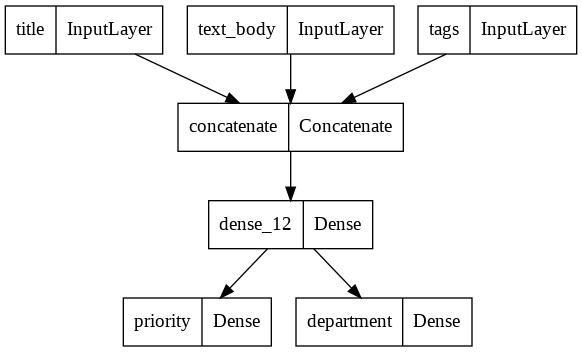

In [37]:
keras.utils.plot_model(model, "ticket_classifier.png")

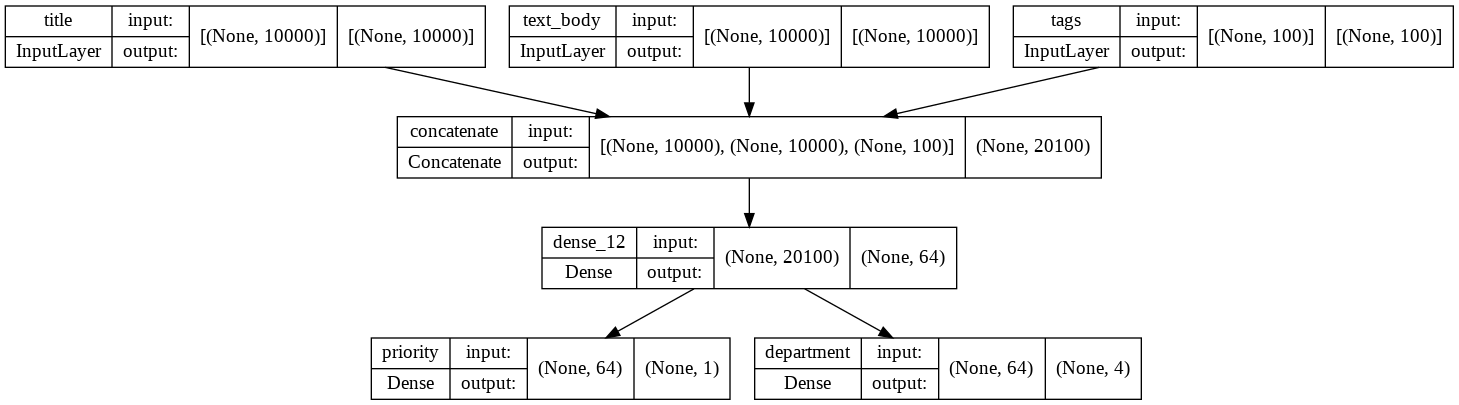

In [38]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

**Retrieving the inputs or outputs of a layer in a Functional model**

Access to layer connectivity also means that you can inspect and reuse individual nodes (layer calls) in the graph.

In [39]:
model.layers

In [40]:
model.layers[3].input                                                                 # 4th layer input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [41]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

Enables us to do feature extraction, creating models that reuse intermediate features from another model.

**Creating a new model by reusing intermediate layer outputs**

In [42]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])                                     # one more output, 'difficulty'

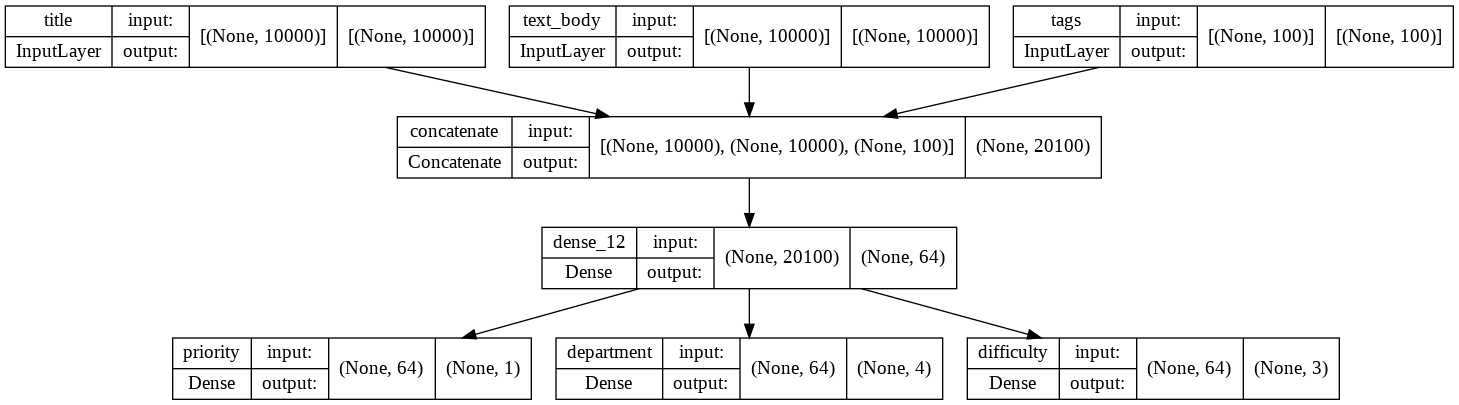

In [43]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

### Subclassing the Model class

#### Rewriting our previous example as a subclassed model

**A simple subclassed model**

In [ ]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()                                                           # define the layers the model will use, Don't forget to call the super() constructor
        self.concat_layer = layers.Concatenate()                                     # Define sublayers in the constructor
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")

    def call(self, inputs):                                                          # Define the forward pass in the call() method, defining the forward pass of the model
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

Instantiate your subclass, and call it on data to create its weights.

In [ ]:
model = CustomerTicketModel(num_departments=4)

priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [ ]:
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

#### Beware: What subclassed models don't support

### Mixing and matching different components

**Creating a Functional model that includes a subclassed model**

In [ ]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

**Creating a subclassed model that includes a Functional model**

In [ ]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

### Remember: Use the right tool for the job

## Using built-in training and evaluation loops

**The standard workflow: `compile()`, `fit()`, `evaluate()`, `predict()`**

In [ ]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

### Writing your own metrics

**Implementing a custom metric by subclassing the `Metric` class**

In [ ]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [ ]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

### Using callbacks

#### The EarlyStopping and ModelCheckpoint callbacks

**Using the `callbacks` argument in the `fit()` method**

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

In [ ]:
model = keras.models.load_model("checkpoint_path.keras")

### Writing your own callbacks

**Creating a custom callback by subclassing the `Callback` class**

In [ ]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

In [ ]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### Monitoring and visualization with TensorBoard

In [ ]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir

## Writing your own training and evaluation loops

### Training versus inference

### Low-level usage of metrics

In [ ]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

In [ ]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

### A complete training and evaluation loop

**Writing a step-by-step training loop: the training step function**

In [ ]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

**Writing a step-by-step training loop: resetting the metrics**

In [ ]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

**Writing a step-by-step training loop: the loop itself**

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

**Writing a step-by-step evaluation loop**

In [ ]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

### Make it fast with tf.function

**Adding a `tf.function` decorator to our evaluation-step function**

In [ ]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

### Leveraging fit() with a custom training loop

**Implementing a custom training step to use with `fit()`**

In [ ]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

## Summary